In [16]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from pathlib import Path
import einops
from torch.utils.tensorboard import SummaryWriter


In [17]:
if torch.cuda.is_available():
    print("GPU is available!")
else:
    print("GPU is not available.")

GPU is not available.


In [18]:
# config
TRAIN = True
IMAGE_SIZE = 16
MODEL_PATH = Path('./models')
MODEL_NAME = 'model.pth'
EPOCHS = 100
BATCHS = 32
EPOCH_STEPS = 1000

TEST_STEP = 999

if not MODEL_PATH.exists():
    MODEL_PATH.mkdir()

if torch.cuda.is_available():
    DEVICE='cuda'
else:
    DEVICE='cpu'

T = 1000 # 时间步长
𝛃 = torch.linspace(0.0001, 0.02, T).to(DEVICE) # 扩散率
𝛂 = 1 - 𝛃
ᾱ = 𝛂.cumprod(dim=0) # 累乘
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
# load minist
train_data = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
dataiter = iter(train_data)
DEVICE

'cpu'

In [19]:
# show images
def imshow(img):
    npimg = img.numpy()
    npimg = einops.rearrange(npimg, 'c h w->h w c')
    plt.imshow(npimg, cmap='gray')
    plt.show()
    
def imshows(imgs, shape, size=(20, 10)):
    fig, axs = plt.subplots(shape[0], shape[1], figsize=(size[0], size[1]))
    for i in range(shape[0]):
        for j in range(shape[1]):
            image = einops.rearrange(imgs[i*shape[1]+j], 'c h w->h w c')
            if shape[0] > 1:
                axs[i, j].imshow(image, cmap='gray')
                axs[i, j].axis('off')
            else:
                axs[j].imshow(image, cmap='gray')
                axs[j].axis('off')
    plt.show()

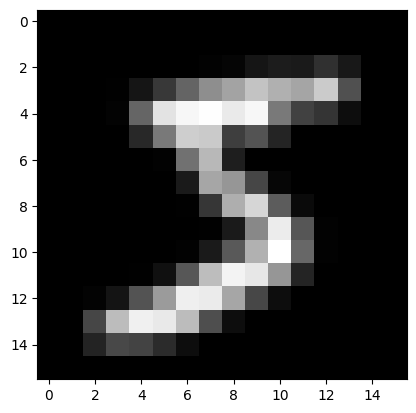

In [20]:
# show some images
image, label = next(dataiter)
imshow(image)

In [21]:
image.shape, label, image.min(), image.max()

(torch.Size([1, 16, 16]), 5, tensor(-1.), tensor(0.9216))

# sample

## noisy_sample

get sample using random timesteps

## noisy_sample_one

get one sample using specify timestep

In [22]:
def noisy_sample(x0, ᾱ, num_sample=3):
    t = torch.randint(0, T, (num_sample,), dtype=torch.long)
    ε = torch.normal(0, 1, (num_sample, 1, IMAGE_SIZE, IMAGE_SIZE)).to(DEVICE)
    ᾱ_t = ᾱ[t].reshape(num_sample, 1, 1, 1)
    xt = (x0[None,...] * ᾱ_t.sqrt() + (1-ᾱ_t).sqrt() * ε)
    xt = (xt - 0.5)/0.5

    return xt, t, ε

def noisy_sample_one(x0, ᾱ, t=1):
    t = torch.tensor(t, dtype=torch.long).to(DEVICE)
    ε = torch.normal(0, 1, (1, 1, IMAGE_SIZE, IMAGE_SIZE)).to(DEVICE)
    ᾱ_t = ᾱ[t].reshape(1, 1, 1, 1)
    xt = (x0 * ᾱ_t.sqrt() + (1-ᾱ_t).sqrt() * ε)

    xt = (xt - 0.5)/0.5
    return xt, ε

torch.Size([1, 1, 16, 16])


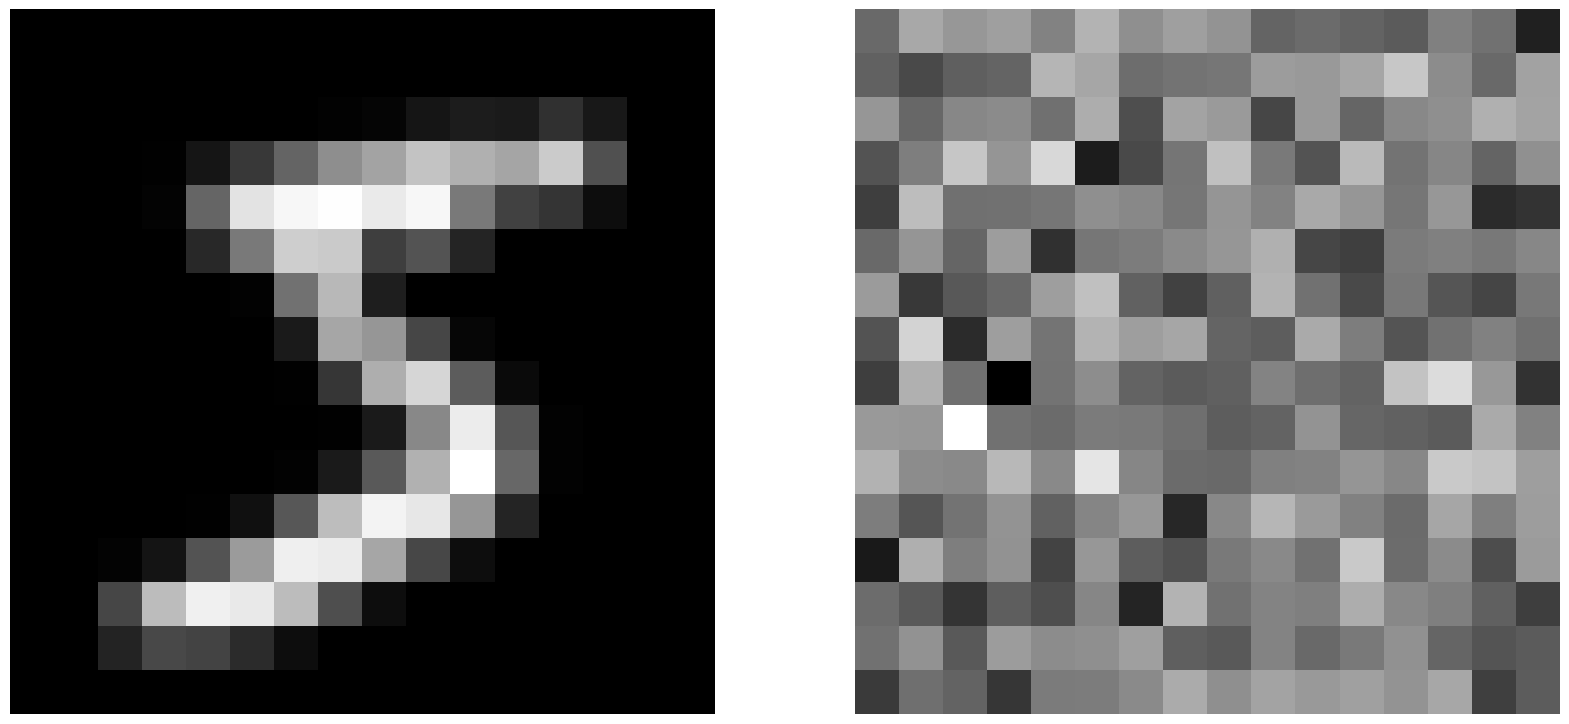

In [23]:
# test sample
org_image = image[None, ...].to(DEVICE)
xT = torch.normal(0, 1, org_image.shape).to(DEVICE)

org_image.shape, xT.shape

xT, noise = noisy_sample_one(org_image, ᾱ.to(DEVICE), TEST_STEP)
print(xT.shape)
x = torch.cat([org_image, xT], dim=0)
imshows(x.cpu(), (1, 2))

In [24]:
!ls models
!pwd

best_ddpm_model.pth model.pth
/Users/cszq/Desktop/study/机器学习模型/code/02model


In [25]:
from diffusers import UNet2DModel

class my_model(torch.nn.Module):
    def __init__(self):
        super(my_model, self).__init__()
        # in_channels=1, out_channels=1, block_out_channels=(16, 32, 64, 128), norm_num_groups=8
        self.model = UNet2DModel(
            sample_size=16, # 2**(len(block_out_channels) - 1)
            in_channels=1, 
            out_channels=1,
            block_out_channels=(32, 64, 64, 64, 128),
            layers_per_block=2,
            down_block_types=("DownBlock2D", "AttnDownBlock2D", "AttnDownBlock2D", "AttnDownBlock2D", "AttnDownBlock2D"),
            up_block_types=("UpBlock2D", "AttnUpBlock2D", "AttnUpBlock2D", "AttnUpBlock2D", "AttnUpBlock2D"),
            )
        # self.model = UNet2DModel()

    #  backward xt->x0
    def forward(self, xt, t):
        t = t.squeeze().float()
        noisy_hat = self.model(xt, t)
        return noisy_hat

model = my_model().to(DEVICE)

print('tring model...')
model.load_state_dict(torch.load(MODEL_PATH/MODEL_NAME, map_location=DEVICE))
print('load model success!')


tring model...
load model success!


100%|██████████| 999/999 [01:45<00:00,  9.47it/s]

torch.Size([1, 1, 16, 16])
torch.Size([1, 1, 16, 16])
torch.Size([1, 1, 16, 16])


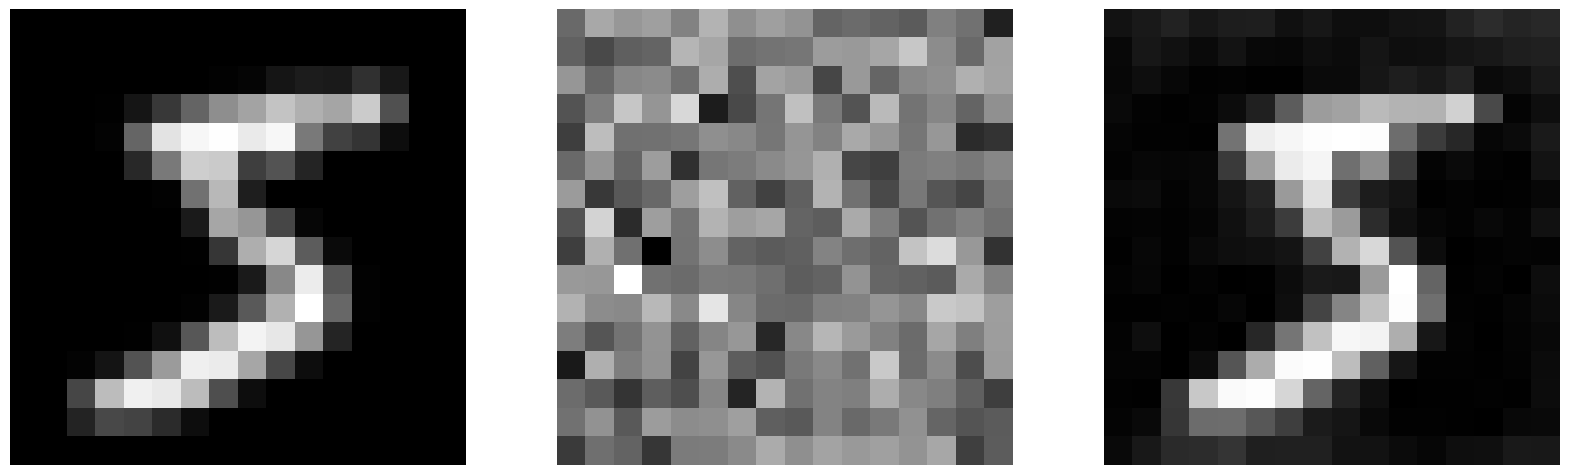

In [26]:
# test model
xt = xT.to(DEVICE)

𝛃 = torch.linspace(0.0001, 0.02, T).to(DEVICE)
𝛂 = (1 - 𝛃).to(DEVICE)
ᾱ = 𝛂.cumprod(dim=0).to(DEVICE)
model.eval()
x_progressive = []

# 可能每步骤多次采样去噪效果更好
LOOP = 5

with torch.no_grad():
    # step by step reverse sample
    for i in tqdm(reversed(range(TEST_STEP)), total=TEST_STEP):

        t = torch.tensor(i, dtype=torch.long).view(-1, 1).to(DEVICE)

        for j in range(LOOP):
        # get noisy_hat add to xt
            noisy_hat = model(xt, t)['sample']

            # use noisy_hat predict by unet calculate x0_hat
            x0_hat = (1/ᾱ[t]).sqrt() * xt - ((1-ᾱ[t])/ᾱ[t]).sqrt()*noisy_hat
            x0_hat = x0_hat.clamp(-1, 1)

            # use x0_hat and xt calculate x-1 mean and variance
            variance_t_1 = (1-𝛂[t]) * (1-ᾱ[t-1]) / (1-ᾱ[t]).view(1,1,1,1)
            mean_t_1 = 𝛂[t].sqrt() * (1-ᾱ[t-1])/(1-ᾱ[t]) * xt + ᾱ[t-1].sqrt() * (1-𝛂[t])/(1-ᾱ[t]) * x0_hat

            # sample x-1
            noise = torch.normal(0, 1, xt.shape).to(DEVICE)
            noisy_mask = 1 if i!=0 else 0
            noisy_mask = torch.tensor(noisy_mask).to(DEVICE)
            xt = mean_t_1 + noisy_mask * variance_t_1.sqrt() * noise
            if i % 10 == 0 and j == 0:
                x_progressive.append(x0_hat)

def my_clip(data):
    min = data.min()
    max = data.max()
    return (data-min)/(max-min)

x0_hat = xt[0].detach().cpu()
x0_hat = my_clip(x0_hat)[None, ...]

print(x0_hat.shape)
print(org_image.shape)
print(xT.shape)

x = torch.cat([org_image.cpu(), xT.cpu(), x0_hat.cpu()], dim=0)

# show org_image, xT, x0
imshows(x.cpu(), (1,3), size=(20,10))


In [27]:
x_progressive = torch.cat(x_progressive, dim=0)
print(x_progressive.shape)

torch.Size([100, 1, 16, 16])


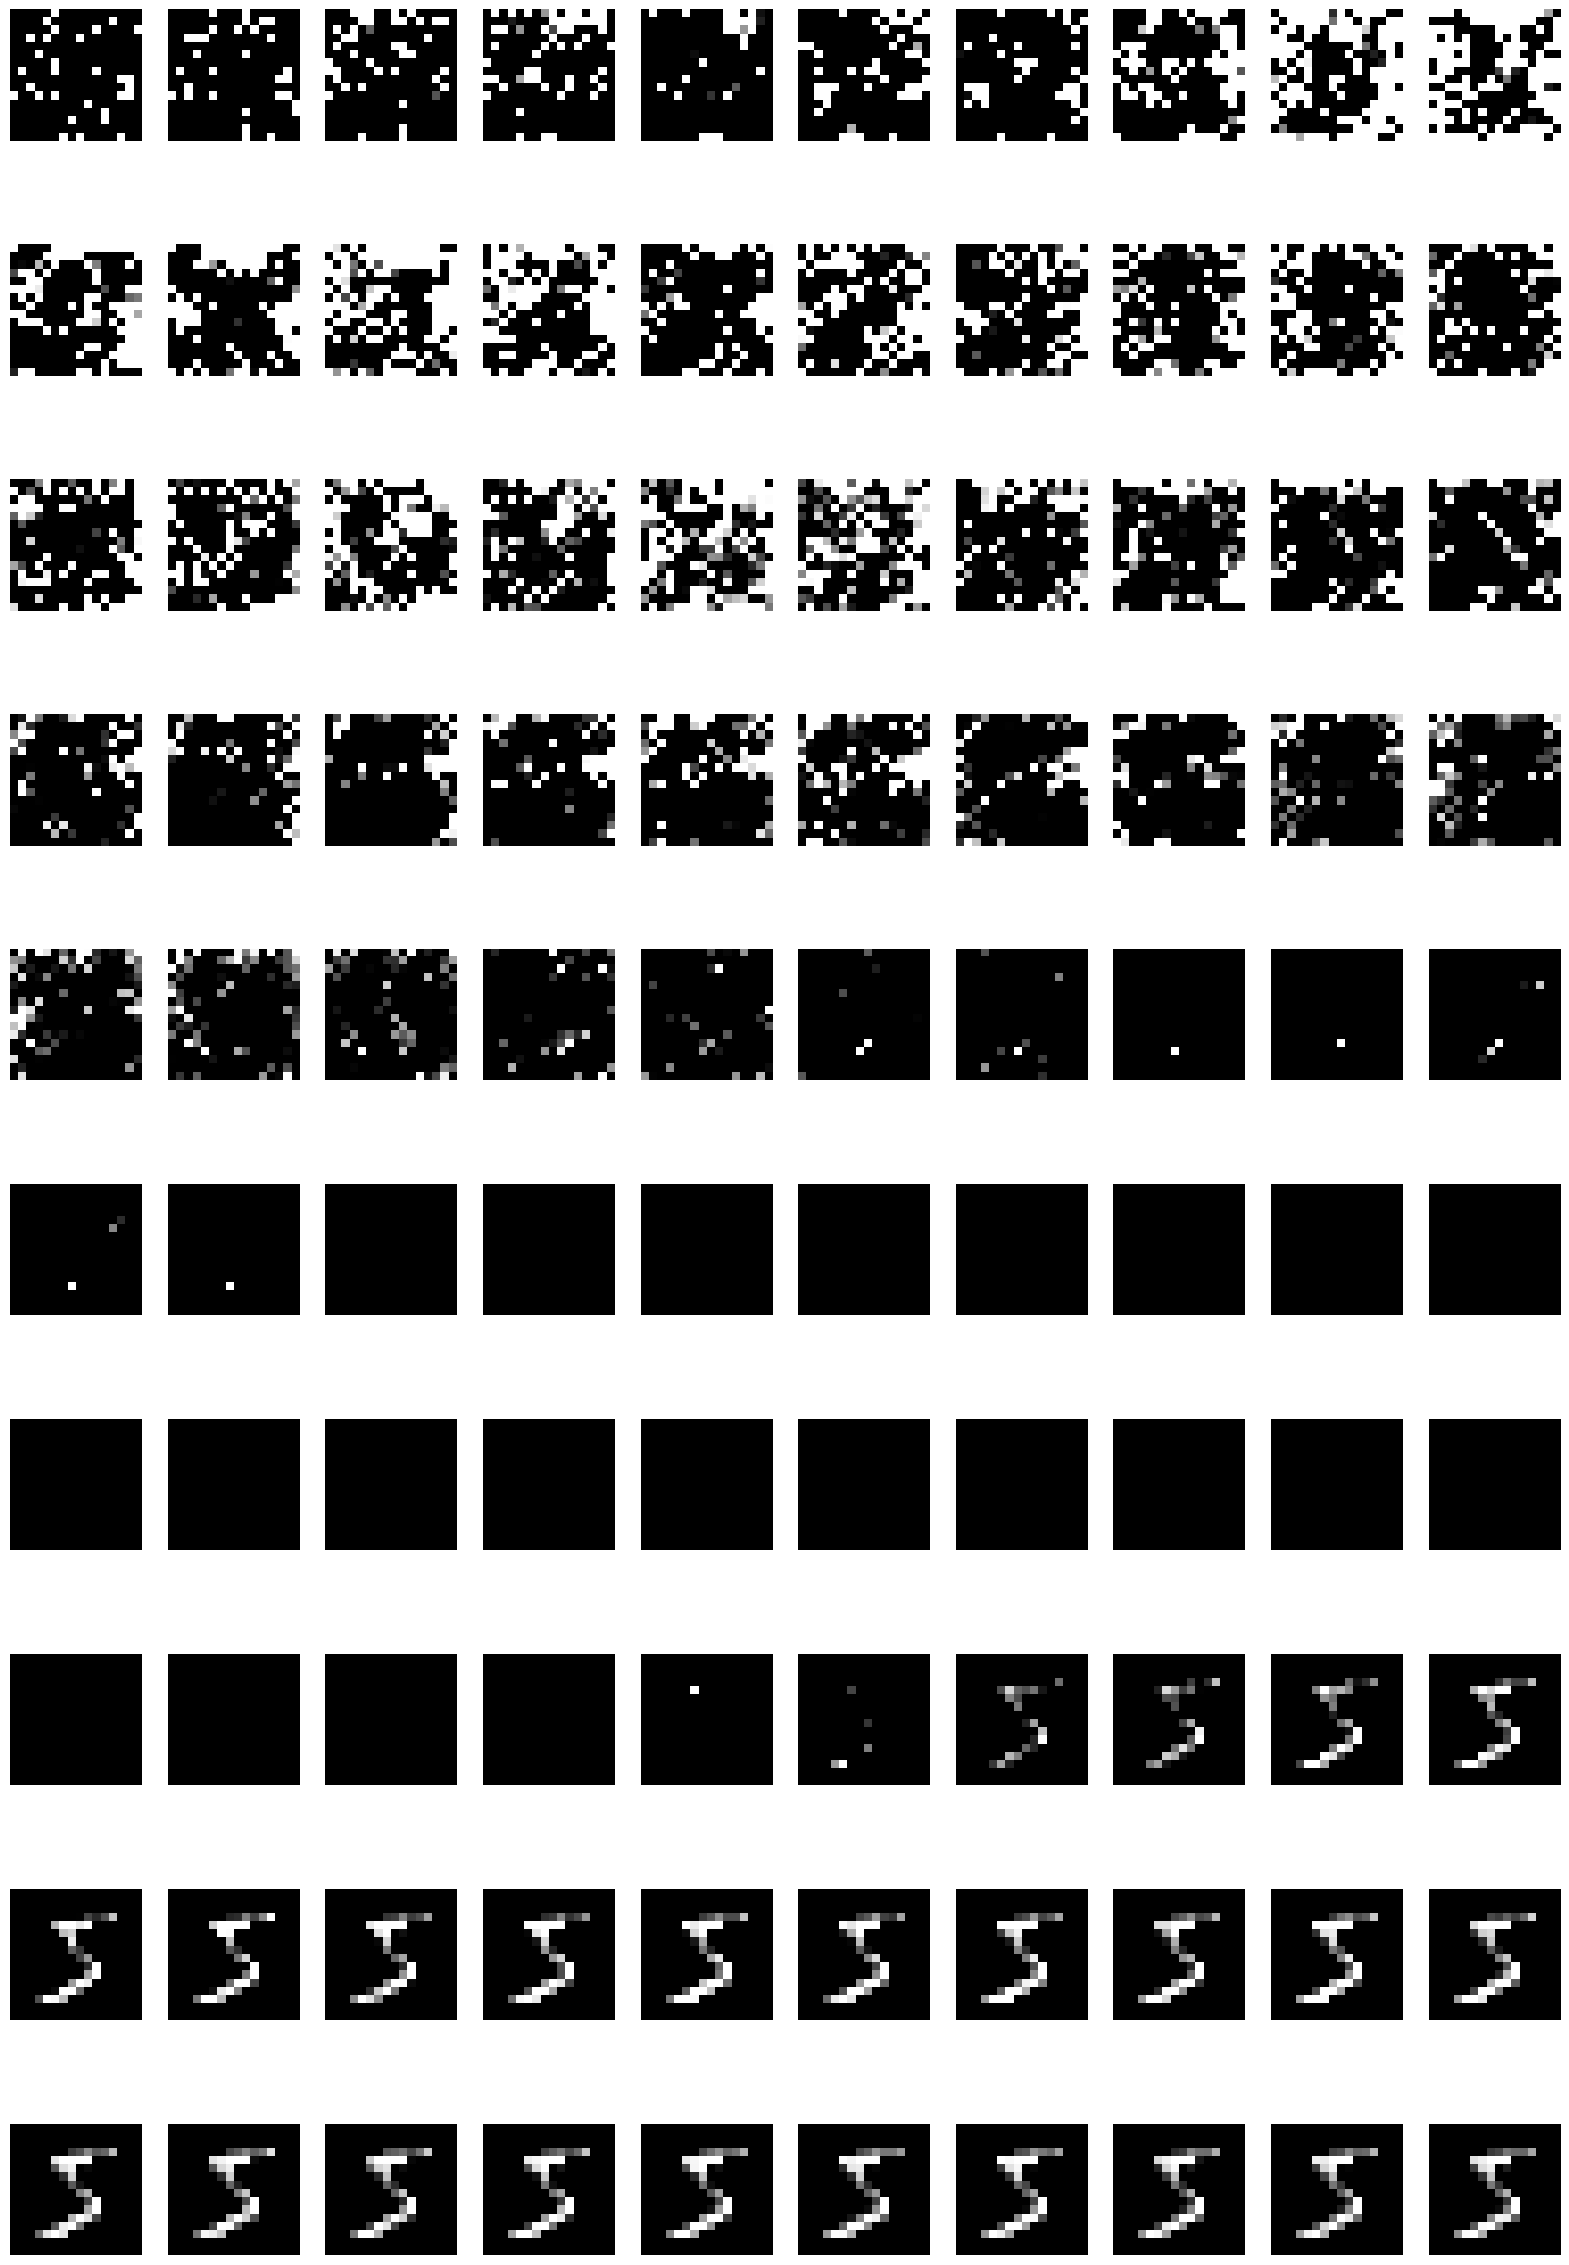

In [28]:
# show x_progressive
imshows(x_progressive.cpu().clamp(0, 1), (10, 10), size=(20,30))

In [29]:
x0 = org_image
# x500, _, noisy = noisy_sample(x0, ᾱ.to(DEVICE), 100)
x500, noisy = noisy_sample_one(x0, ᾱ.to(DEVICE), 500)
noisy_hat = model(x500, torch.tensor(1, dtype=torch.long).to(DEVICE))['sample']

# mse
mse = torch.nn.MSELoss()
loss = mse(noisy_hat, noisy)
print(loss)

print(((noisy_hat - noisy)**2).sum())

tensor(0.0220, grad_fn=<MseLossBackward0>)
tensor(5.6379, grad_fn=<SumBackward0>)
